# IMDB Data Cleaning and initial checks

![IMDB Logo](https://cdn.prod.website-files.com/626fae216404de74c2539b98/633558f4ed4b31fead1f3382_8.png)

In [1]:
import sqlite3
from sqlalchemy import create_engine,inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
import plotly.express as px


#read sql-murder-mystery.db datdabse using create_engine
engine = create_engine("sqlite:///../unzippedData/im.db")

#connect to database eninge
db_connect = engine.connect()

In [2]:
inspection = inspect(engine)
inspection.get_table_names()

['directors',
 'known_for',
 'movie_akas',
 'movie_basics',
 'movie_ratings',
 'persons',
 'principals',
 'writers']


Loading the sql dataset into a DataFrame.

---

In [3]:
#run sql command to select all records in the three tables we're interested in i.e movie baics,movie ratings and movie akas

#Write SQL query joining the three tables
query = """
SELECT 
    b.movie_id,
    b.primary_title,
    b.start_year,
    b.runtime_minutes,
    b.genres,
    r.averagerating,
    r.numvotes,
    a.title AS aka_title,
    a.region,
    a.language
FROM movie_basics b
LEFT JOIN movie_ratings r
    ON b.movie_id = r.movie_id
LEFT JOIN movie_akas a
    ON b.movie_id = a.movie_id
"""

# 3. Load result into a Pandas DataFrame
df = pd.read_sql(query, engine)
df.head

<bound method NDFrame.head of          movie_id                                primary_title  start_year  \
0       tt0063540                                    Sunghursh        2013   
1       tt0063540                                    Sunghursh        2013   
2       tt0063540                                    Sunghursh        2013   
3       tt0063540                                    Sunghursh        2013   
4       tt0063540                                    Sunghursh        2013   
...           ...                                          ...         ...   
355540  tt9916538                          Kuambil Lagi Hatiku        2019   
355541  tt9916622  Rodolpho Teóphilo - O Legado de um Pioneiro        2015   
355542  tt9916706                              Dankyavar Danka        2013   
355543  tt9916730                                       6 Gunn        2017   
355544  tt9916754               Chico Albuquerque - Revelações        2013   

        runtime_minutes          

In [4]:
#close database connection
db_connect.close()

### General data analysis or processing


In [5]:
df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,aka_title,region,language
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,Sangharsh,IN,hi
1,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,Sungharsh,IN,hi
2,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,Sunghursh,None,None
3,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,Sunghursh,IN,None
4,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,Sunghursh,IN,hi


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355545 entries, 0 to 355544
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         355545 non-null  object 
 1   primary_title    355545 non-null  object 
 2   start_year       355545 non-null  int64  
 3   runtime_minutes  314219 non-null  float64
 4   genres           348882 non-null  object 
 5   averagerating    266085 non-null  float64
 6   numvotes         266085 non-null  float64
 7   aka_title        331703 non-null  object 
 8   region           278410 non-null  object 
 9   language         41715 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 27.1+ MB


In [7]:
#Handle duplicates
df = df.drop_duplicates(subset=['movie_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146144 entries, 0 to 355544
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   averagerating    73856 non-null   float64
 6   numvotes         73856 non-null   float64
 7   aka_title        122302 non-null  object 
 8   region           99869 non-null   object 
 9   language         7979 non-null    object 
dtypes: float64(3), int64(1), object(6)
memory usage: 12.3+ MB


In [8]:
#Check missing values 
# Check percentage of missing values per column
print("Percentage of missing values per column:")
print((df.isna().sum() / len(df)) * 100)

Percentage of missing values per column:
movie_id            0.000000
primary_title       0.000000
start_year          0.000000
runtime_minutes    21.717621
genres              3.700460
averagerating      49.463543
numvotes           49.463543
aka_title          16.314046
region             31.663975
language           94.540316
dtype: float64


In [9]:
#Check missing values
df.isnull().sum()

movie_id                0
primary_title           0
start_year              0
runtime_minutes     31739
genres               5408
averagerating       72288
numvotes            72288
aka_title           23842
region              46275
language           138165
dtype: int64

In [10]:
#Handle runtime_minutes missing values by replacing with median time
median_val = df["runtime_minutes"].median()

df.loc[:, "runtime_minutes"] = df["runtime_minutes"].fillna(median_val)

In [11]:
# --- Handle unkown genres ---
df.loc[:,['genres','region','language']] = df[['genres','region','language']].fillna('Unknown')

In [12]:
# Drop movies with <1000 votes or missing ratings so as to not skew the reults
df = df.dropna(subset=['averagerating', 'numvotes'])
df = df[df['numvotes'] >= 1000]

In [13]:
#Replace missing aka titles with the primary title
df['aka_title'] = df['aka_title'].fillna(df['primary_title'])

In [14]:
df.isnull().sum()

movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
aka_title          0
region             0
language           0
dtype: int64

### Explanation
This block performs general data analysis or processing.

---

In [15]:
#Check movie years
start_year,end_year = df['start_year'].min(),df['start_year'].max()
start_year,end_year

(np.int64(2010), np.int64(2019))

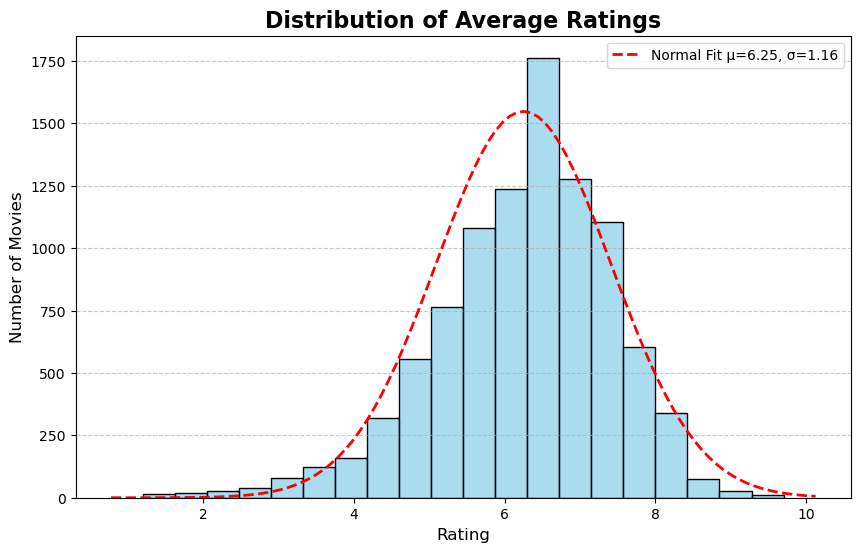

In [16]:
# Pick the column to plot
data = df['averagerating']

plt.figure(figsize=(10,6))

# Histogram with Seaborn styling
sns.histplot(data, bins=20, kde=False, color="skyblue", edgecolor="black", alpha=0.7)

# Overlay a fitted normal distribution curve from scipy
mu, std = stats.norm.fit(data)  # mean & std
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p * len(data) * (xmax - xmin) / 20, "r--", linewidth=2, label=f"Normal Fit μ={mu:.2f}, σ={std:.2f}")

# Make it flashy with titles and labels
plt.title("Distribution of Average Ratings", fontsize=16, fontweight="bold")
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

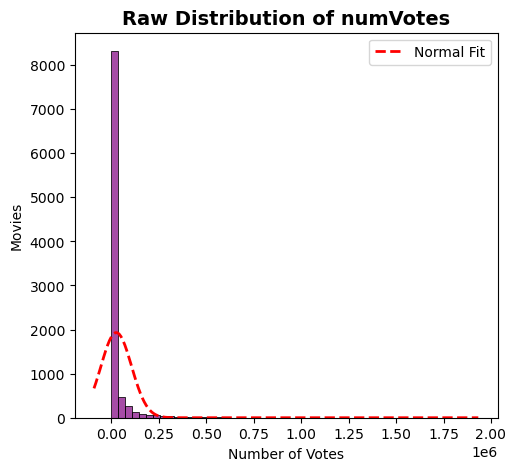

In [17]:
# Drop missing
data = df['numvotes']

# --- Raw Distribution ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(data, bins=50, color="purple", edgecolor="black", alpha=0.7)
mu, std = stats.norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p * len(data) * (xmax - xmin) / 50, "r--", linewidth=2, label=f"Normal Fit")
plt.title("Raw Distribution of numVotes", fontsize=14, fontweight="bold")
plt.xlabel("Number of Votes")
plt.ylabel("Movies")
plt.legend()


Applying log transformation to reduce skewness.


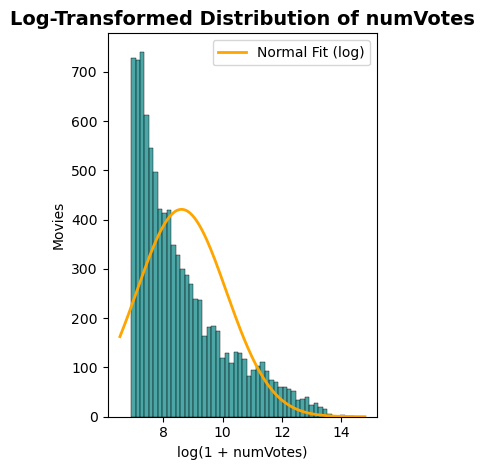

In [18]:
plt.subplot(1,2,2)
log_data = np.log1p(data)  # log(1+x)
sns.histplot(log_data, bins=50, color="teal", edgecolor="black", alpha=0.7)
mu_log, std_log = stats.norm.fit(log_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = stats.norm.pdf(x, mu_log, std_log)
plt.plot(x, p * len(log_data) * (xmax - xmin) / 50, "orange", linewidth=2, label=f"Normal Fit (log)")
plt.title("Log-Transformed Distribution of numVotes", fontsize=14, fontweight="bold")
plt.xlabel("log(1 + numVotes)")
plt.ylabel("Movies")
plt.legend()

plt.tight_layout()
plt.show()

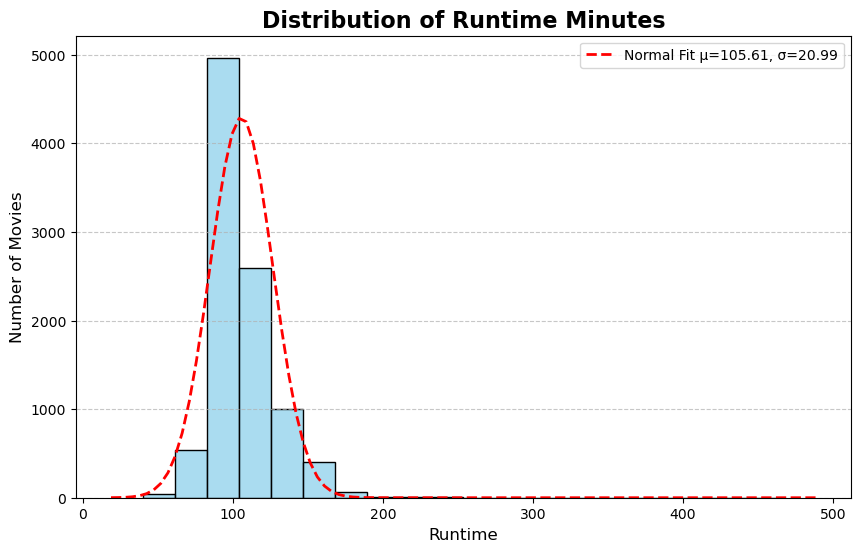

In [19]:
# Pick the column to plot
data = df['runtime_minutes']

plt.figure(figsize=(10,6))

# Histogram with Seaborn styling
sns.histplot(data, bins=20, kde=False, color="skyblue", edgecolor="black", alpha=0.7)

# Overlay a fitted normal distribution curve from scipy
mu, std = stats.norm.fit(data)  # mean & std
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p * len(data) * (xmax - xmin) / 20, "r--", linewidth=2, label=f"Normal Fit μ={mu:.2f}, σ={std:.2f}")

# Make it flashy with titles and labels
plt.title("Distribution of Runtime Minutes", fontsize=16, fontweight="bold")
plt.xlabel("Runtime", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



Checking correlation between average rating,number of votes and runtime minutes

---

<Axes: >

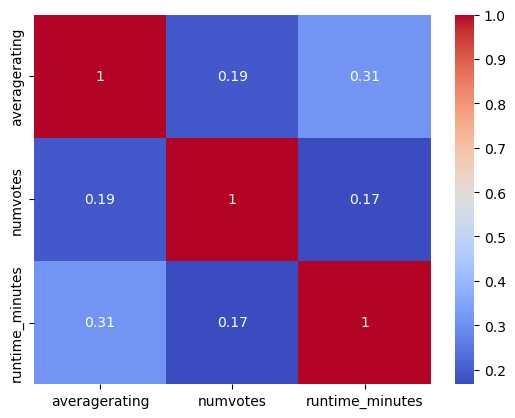

In [20]:
corr = df[['averagerating','numvotes','runtime_minutes']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

### Conclusion

There's very littel correlation between the three above columns, which means the length of the movie doesn't significantly affect it's average rating

---

### Further checks of correlation

Checking the correlation using linear regression to confirm the above

---

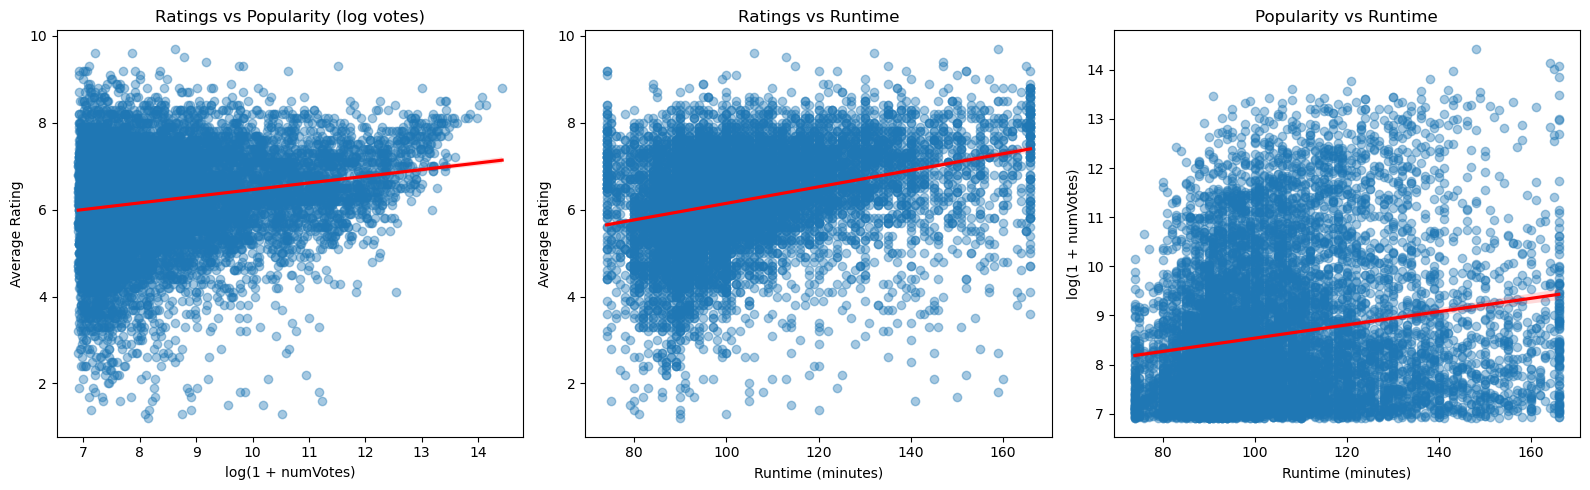

In [21]:
#Use regression to check strength of the relationships
# Log transform numVotes to reduce skew



df['runtime_winsorized'] = winsorize(df['runtime_minutes'], limits=[0.01, 0.01]) #Removes outliers via percentiles i.e at 1st and 99th percentile
df['log_numVotes'] = np.log1p(df['numvotes'])

plt.figure(figsize=(16,5))

# 1. Ratings vs Popularity
plt.subplot(1,3,1)
sns.regplot(x="log_numVotes", y="averagerating", data=df,
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("Ratings vs Popularity (log votes)")
plt.xlabel("log(1 + numVotes)")
plt.ylabel("Average Rating")

# 2. Ratings vs Runtime
plt.subplot(1,3,2)
sns.regplot(x="runtime_winsorized", y="averagerating", data=df,
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("Ratings vs Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Rating")

# 3. Popularity vs Runtime
plt.subplot(1,3,3)
sns.regplot(x="runtime_winsorized", y="log_numVotes", data=df,
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("Popularity vs Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("log(1 + numVotes)")

plt.tight_layout()
plt.show()

#### Check relationship between different genres and the averagerating

Using an ANOVA test to check whether different genres affect the average rating

In [22]:
#ANOVA test to check whether different genres affect the averagerating

from scipy.stats import f_oneway

# Pick 3 example genres
action = df[df["genres"].str.contains("Action")]["averagerating"]
drama = df[df["genres"].str.contains("Drama")]["averagerating"]
comedy = df[df["genres"].str.contains("Comedy")]["averagerating"]

f_stat, p_val = f_oneway(action, drama, comedy)
print(f"F-statistic: {f_stat}, p-value: {p_val}")

F-statistic: 188.51042081386464, p-value: 4.262680143369571e-81


### Conclusion

The p-value is way lower than our alpha 0.05, so there's a strong relationship between the movie genres and the ratings

---

#### TOP 10 Movie Genres

Checking the top 10 genres based on average rating

---

In [23]:
# Split genres into individual tags
df_genres = df.assign(genre=df["genres"].str.split(",")).explode("genre")

# Group by single genre and get mean rating
genre_ratings = df_genres.groupby("genre")["averagerating"].mean().sort_values(ascending=False)

print("Top genres by average rating:")
print(genre_ratings.head(10))

Top genres by average rating:
genre
News           7.722222
Unknown        7.550000
Documentary    7.267611
Biography      6.957347
Sport          6.932653
History        6.893540
Music          6.750177
War            6.720859
Animation      6.682713
Musical        6.537143
Name: averagerating, dtype: float64


### Best genre combinations rating

Checking the top 10 genre combinations based on average rating

In [24]:
# Group by the full genre combination string
combo_ratings = df.groupby("genres")["averagerating"].mean().sort_values(ascending=False)

print("Top genre combinations by average rating:")
print(combo_ratings.head(10))

Top genre combinations by average rating:
genres
Action,Romance,War               8.500000
Drama,Family,Thriller            8.300000
Animation,History                8.300000
War                              8.200000
Animation,Documentary,Mystery    8.200000
Musical                          8.180000
Biography,Documentary,News       8.100000
Documentary,History,Sport        8.033333
Action,Documentary               8.000000
Animation,Fantasy,Mystery        8.000000
Name: averagerating, dtype: float64


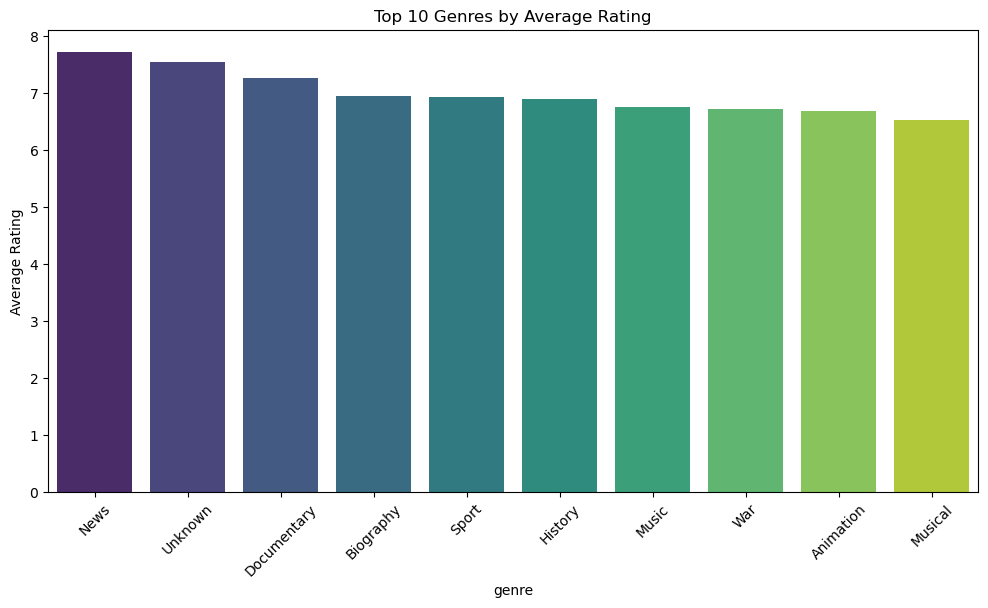

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(x=genre_ratings.head(10).index, y=genre_ratings.head(10).values,palette="viridis",hue=genre_ratings.head(10).index, legend=False)
plt.xticks(rotation=45)
plt.title("Top 10 Genres by Average Rating")
plt.ylabel("Average Rating")
plt.show()

### Yearly trends

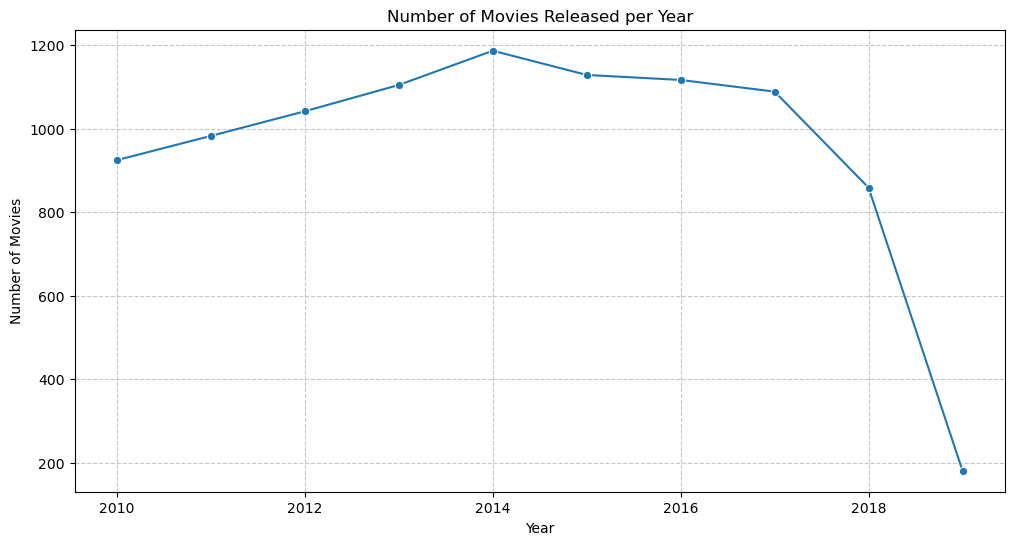

In [26]:
# Count of movies per year
movies_per_year = df.groupby("start_year").size()

plt.figure(figsize=(12,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker='o')
plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

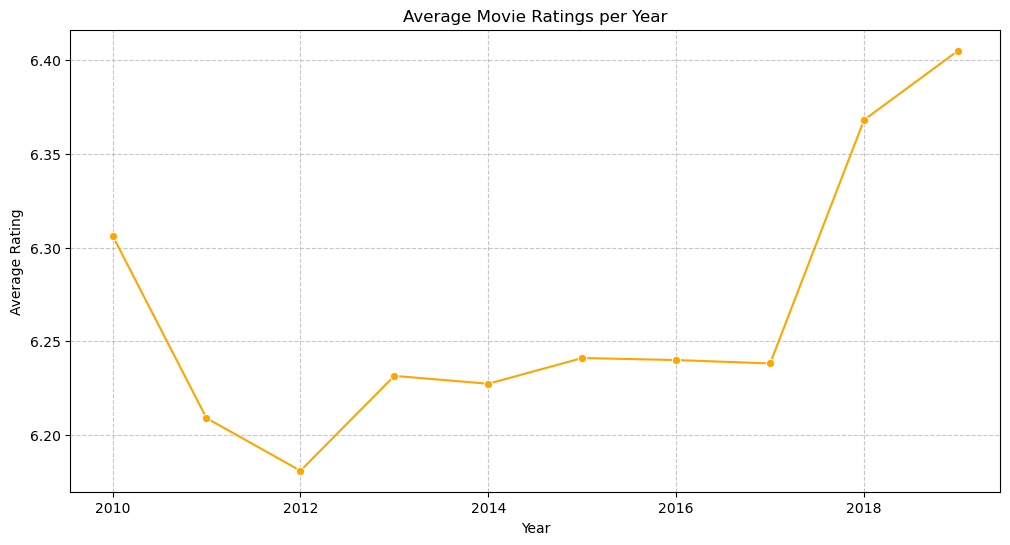

In [27]:
ratings_per_year = df.groupby("start_year")["averagerating"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values, marker='o', color='orange')
plt.title("Average Movie Ratings per Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [28]:


# Prepare the data
df_genres = df.assign(genre=df["genres"].str.split(",")).explode("genre")
genre_ratings_year = df_genres.groupby(["start_year","genre"])["averagerating"].mean().reset_index()

# Interactive line chart with tooltips
fig = px.line(
    genre_ratings_year, 
    x="start_year", 
    y="averagerating", 
    color="genre",
    hover_data={"genre": True, "start_year": True, "averagerating": ':.2f'},  # tooltip formatting
    title="Average Ratings per Genre Over Time"
)

# Optional: adjust layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Rating",
    legend_title="Genre",
    hovermode="x unified"
)

fig.show()

### Explanation
This block performs general data analysis or processing.

---

In [29]:

# Split genres into individual rows
df_genres = df.assign(genre=df["genres"].str.split(",")).explode("genre")

# Compute overall average rating per genre
overall_genre_ratings = df_genres.groupby("genre")["averagerating"].mean().sort_values(ascending=False)
top5_genres = overall_genre_ratings.head(5).index.tolist()

# Filter to top 5 genres
top5_df = df_genres[df_genres["genre"].isin(top5_genres)]

# Average rating per year per genre
genre_ratings_year = top5_df.groupby(["start_year","genre"])["averagerating"].mean().reset_index()

# Interactive line chart with markers and tooltips
fig = px.line(
    genre_ratings_year,
    x="start_year",
    y="averagerating",
    color="genre",
    markers=True,
    hover_data={"genre": True, "start_year": True, "averagerating": ':.2f'},
    title="Average Ratings per Year for Top 5 Genres"
)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Rating",
    legend_title="Genre",
    hovermode="x unified"
)

fig.show()

In [30]:
#Exporting the cleaned csv file to combine with the 
df.to_csv("cleaned_imdb.csv", index=False)


# Final Conclusions (IMDB Data Analysis)

- **Distributions:** Runtime, votes, and ratings were checked for normality. Some skewness was observed, corrected using log transformations.  
- **Scatterplots:** Showed weak but visible trends (e.g., longer runtimes sometimes linked to higher popularity, though with outliers).  
- **Group Comparisons:** ANOVA and t-tests indicated that genres have statistically significant differences in ratings and votes.  
- **Genres:** Action, Drama, and Comedy dominated volume, while combinations like Action + Adventure scored higher average ratings.  
- **Yearly Trends:** Ratings and production output fluctuated over years, with clear spikes for certain genres.  

Overall: IMDB data shows that **genres and runtime play moderate roles in ratings/popularity**, but external factors (like budget, marketing, franchises) are likely stronger drivers of box office performance.
